In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets

%matplotlib widget
# %matplotlib inline

In [2]:
freq_min = 25000000
freq_max = 25000000

n_banks_min = 2
n_banks_max = 2

n_rows_min = 32
n_rows_max = 64*2
n_rows_step = 32

n_cols_min = 32
n_cols_max = 64*10
n_cols_step = 32

n_planes_min = 1
n_planes_max = 20

bcm_lsb_len_min = 0
bcm_lsb_len_max = 300

overhead = 3

In [3]:
%%time
results = []

# print(results)
for freq in range(freq_min, freq_max + 1):
  for n_banks in range(n_banks_min, n_banks_max + 1):
    for n_rows in range(n_rows_min, n_rows_max + 1, n_rows_step):
      for n_cols in range(n_cols_min, n_cols_max + 1, n_cols_step):
        for n_planes in range(n_planes_min, n_planes_max + 1):
          for bcm_lsb_len in range(bcm_lsb_len_min, bcm_lsb_len_max + 1):
            
            bcm_cycles = n_rows * sum(bcm_lsb_len << i for i in range(0, n_planes))
            display_cycles = n_rows * sum(max(bcm_lsb_len << i, n_cols) + overhead for i in range(0, n_planes))
            
#             bcm_cycles = n_rows * sum(bcm_lsb_len * 2 ** i for i in range(0, n_planes))
#             display_cycles = n_rows * sum(max(bcm_lsb_len * 2 ** i, n_cols) + overhead for i in range(0, n_planes))
            
            results.append([freq, n_banks, n_rows, n_cols, n_planes, bcm_lsb_len, bcm_cycles / display_cycles, freq / display_cycles, bcm_cycles, display_cycles])

results_df = pd.DataFrame(results, columns = ['freq', 'n_banks', 'n_rows', 'n_cols', 'n_planes', 'bcm_lsb_len', 'light_efficiency', 'refresh_rate', 'bcm_cycles', 'display_cycles'])

CPU times: user 3.26 s, sys: 197 ms, total: 3.46 s
Wall time: 3.46 s


In [4]:
@widgets.interact(n_rows=(n_rows_min, n_rows_max, n_rows_step),
                  n_cols=(n_cols_min, n_cols_max, n_cols_step),
                  n_planes=(n_planes_min, n_planes_max),
                  refresh_rate = (0, 1000),
                  light_efficiency = (0, 1, 0.01))

def update(n_rows = 32, n_cols = 32, n_planes = 8, refresh_rate = 100, light_efficiency = 0.5):
    display(results_df.loc[(results_df['n_rows'] == n_rows) & (results_df['n_cols'] == n_cols) & (results_df['n_planes'] == n_planes) & (results_df['refresh_rate'] >= refresh_rate) & (results_df['light_efficiency'] >= light_efficiency)].reset_index(drop=True))

interactive(children=(IntSlider(value=32, description='n_rows', max=128, min=32, step=32), IntSlider(value=32,…

interactive(children=(IntSlider(value=32, description='n_col', max=640, min=32, step=32), IntSlider(value=8, d…

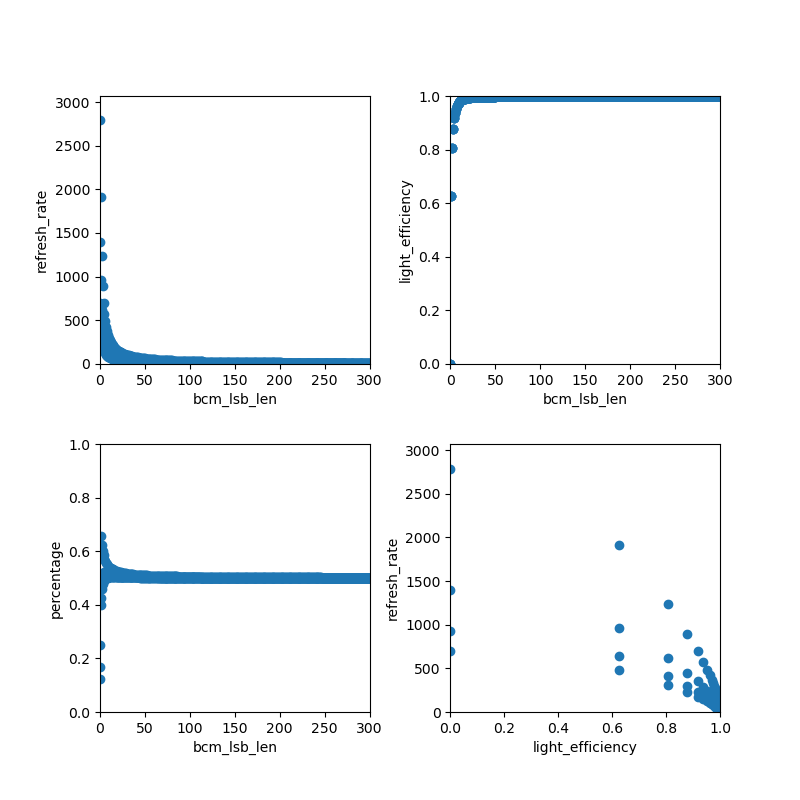

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

@widgets.interact(n_col=(n_cols_min, n_cols_max, n_cols_step), 
                  n_planes=(n_planes_min, n_planes_max),
                  bcm_lsb_len = (bcm_lsb_len_min, bcm_lsb_len_max),
                  bcm_lsb_len2 = (bcm_lsb_len_min, bcm_lsb_len_max),
                  refresh_weight = (0, 1, 0.1))

def update(n_col = 32, n_planes = 8, bcm_lsb_len = bcm_lsb_len_max, bcm_lsb_len2 = bcm_lsb_len_max, refresh_weight = 0.5):
    # Remove old line from plot
    [l.remove() for l in ax1.lines] 
    [l.remove() for l in ax2.lines] 
    [l.remove() for l in ax3.lines] 
    [l.remove() for l in ax4.lines] 
    
    # Filter out lines that won't be graphed
    filtered = results_df.loc[(results_df['n_cols'] == n_col) & (results_df['n_planes'] == n_planes) & (results_df['bcm_lsb_len'] <= bcm_lsb_len)].reset_index(drop=True)
    
    # Calculate weighted percentage of refresh rate and light efficiency
    light_weight = 1 - refresh_weight
    filtered['percentage'] = (filtered['light_efficiency'] / filtered['light_efficiency'].max() * light_weight) + (filtered['refresh_rate'] / filtered['refresh_rate'].max() * refresh_weight)
    
    # Calculate and print the optimal bcm_lsb_len and record its refresh_rate and light_efficiency
    results = filtered.iloc[filtered['percentage'].idxmax()]
    print(f"n_cols:{results['n_cols'] : .0f}")
    print(f"n_planes:{results['n_planes'] : .0f}")
    print(f"bcm_lsb_len:{results['bcm_lsb_len'] : .0f}")
    print(f"refresh_rate:{results['refresh_rate'] : .2f}")
    print(f"light_efficiency:{results['light_efficiency'] : .4f}")
    
    ## Set the x and y limits on the graphs
    ax1.set_ylim([0, filtered['refresh_rate'].max() * 1.1])
    ax2.set_ylim([0, 1])
    ax3.set_ylim([0, 1])
    ax4.set_ylim([0, filtered['refresh_rate'].max() * 1.1])
    
    ax1.set_xlim([0, filtered['bcm_lsb_len'].max()])
    ax2.set_xlim([0, filtered['bcm_lsb_len'].max()])
    ax3.set_xlim([0, filtered['bcm_lsb_len'].max()])
    ax4.set_xlim([0, 1])
    
    # Set x and y labels
    ax1.set_xlabel('bcm_lsb_len')
    ax2.set_xlabel('bcm_lsb_len')
    ax3.set_xlabel('bcm_lsb_len')
    ax4.set_xlabel('light_efficiency')
    
    ax1.set_ylabel('refresh_rate')
    ax2.set_ylabel('light_efficiency')
    ax3.set_ylabel('percentage')
    ax4.set_ylabel('refresh_rate')

    # Plot the graphs
    ax1.plot(filtered['bcm_lsb_len'], filtered['refresh_rate'], 'o', color='C0')
    ax2.plot(filtered['bcm_lsb_len'], filtered['light_efficiency'], 'o', color='C0')
    ax3.plot(filtered['bcm_lsb_len'], filtered['percentage'], 'o', color='C0')
    ax4.plot(filtered['light_efficiency'], filtered['refresh_rate'], 'o', color='C0')

In [28]:
n_rows = 64
bitdepth = 8
bcm_lsb_len = 10 / 2
n_cols = 64
freq = 25000000
overhead = 3

bcm_cycles = n_rows * sum(bcm_lsb_len * 2 ** i for i in range(0, bitdepth))
display_cycles = n_rows * sum(max(bcm_lsb_len * 2 ** i, n_cols) + overhead for i in range(0, bitdepth))

print(f"bcm cycles: {bcm_cycles}")
print(f"display cycles: {display_cycles}")
print(f"refresh rate:{freq / display_cycles : .2f}")
print(f"light efficiency:{bcm_cycles / display_cycles : .4f}")

bcm cycles: 40640.0
display cycles: 53568.0
refresh rate: 466.70
light efficiency: 0.7587


n_cols: 256
n_rows: 32
n_planes: 8
bcm_lsb_len: 16
refresh_rate: 159.83
light_efficiency: 0.8347


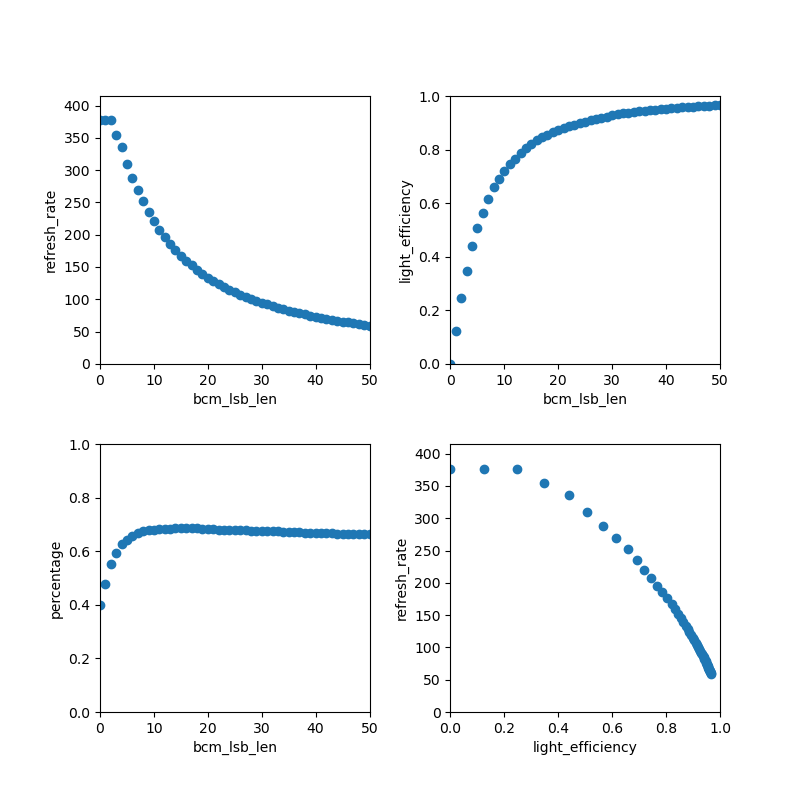

In [61]:
n_col = 64*4
n_rows = 32
n_planes = 8
bcm_lsb_len = 50
refresh_weight = 0.4

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)
   
# Filter out lines that won't be graphed
filtered = results_df.loc[(results_df['n_cols'] == n_col) & (results_df['n_rows'] == n_rows) & (results_df['n_planes'] == n_planes) & (results_df['bcm_lsb_len'] <= bcm_lsb_len)].reset_index(drop=True)
    
# Calculate weighted percentage of refresh rate and light efficiency
light_weight = 1 - refresh_weight
filtered['percentage'] = (filtered['light_efficiency'] / filtered['light_efficiency'].max() * light_weight) + (filtered['refresh_rate'] / filtered['refresh_rate'].max() * refresh_weight)
    
# Calculate and print the optimal bcm_lsb_len and record its refresh_rate and light_efficiency
results = filtered.iloc[filtered['percentage'].idxmax()]
print(f"n_cols:{results['n_cols'] : .0f}")
print(f"n_rows:{results['n_rows'] : .0f}")
print(f"n_planes:{results['n_planes'] : .0f}")
print(f"bcm_lsb_len:{results['bcm_lsb_len'] : .0f}")
print(f"refresh_rate:{results['refresh_rate'] : .2f}")
print(f"light_efficiency:{results['light_efficiency'] : .4f}")
    
## Set the x and y limits on the graphs
ax1.set_ylim([0, filtered['refresh_rate'].max() * 1.1])
ax2.set_ylim([0, 1])
ax3.set_ylim([0, 1])
ax4.set_ylim([0, filtered['refresh_rate'].max() * 1.1])
    
ax1.set_xlim([0, filtered['bcm_lsb_len'].max()])
ax2.set_xlim([0, filtered['bcm_lsb_len'].max()])
ax3.set_xlim([0, filtered['bcm_lsb_len'].max()])
ax4.set_xlim([0, 1])
    
# Set x and y labels
ax1.set_xlabel('bcm_lsb_len')
ax2.set_xlabel('bcm_lsb_len')
ax3.set_xlabel('bcm_lsb_len')
ax4.set_xlabel('light_efficiency')
    
ax1.set_ylabel('refresh_rate')
ax2.set_ylabel('light_efficiency')
ax3.set_ylabel('percentage')
ax4.set_ylabel('refresh_rate')

# Plot the graphs
ax1.plot(filtered['bcm_lsb_len'], filtered['refresh_rate'], 'o', color='C0')
ax2.plot(filtered['bcm_lsb_len'], filtered['light_efficiency'], 'o', color='C0')
ax3.plot(filtered['bcm_lsb_len'], filtered['percentage'], 'o', color='C0')
ax4.plot(filtered['light_efficiency'], filtered['refresh_rate'], 'o', color='C0')
